### Recording Audio

In [76]:
import random

import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
import tensorflow as tf
import keras as k
import sounddevice as sd
import uuid
import json
import math

In [77]:
#sample a sound from sound device and visualise it
# f = 1/T ==> T = duration * fs
# fs = 44100 Hz base frequency
fs = 44100
duration = 2
val = sd.rec(frames=fs*duration, samplerate=fs, channels=1)
sd.wait()
print("results: ",val.shape, val)



results:  (88200, 1) [[ 0.0000000e+00]
 [ 0.0000000e+00]
 [-3.0517578e-05]
 ...
 [ 6.1035156e-04]
 [ 5.4931641e-04]
 [ 6.1035156e-04]]


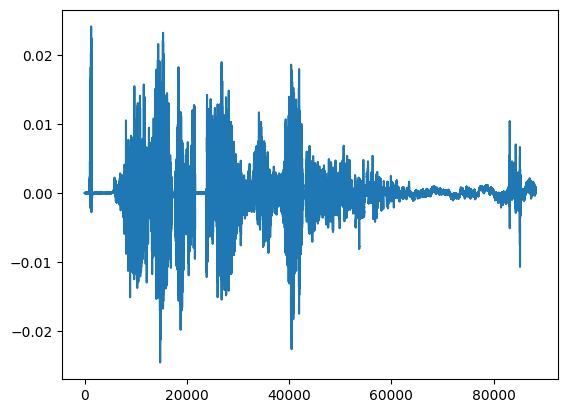

In [78]:
plt.plot(val)


In [79]:
np.save('test.npy', val)


In [80]:
val1 = np.load('test.npy')

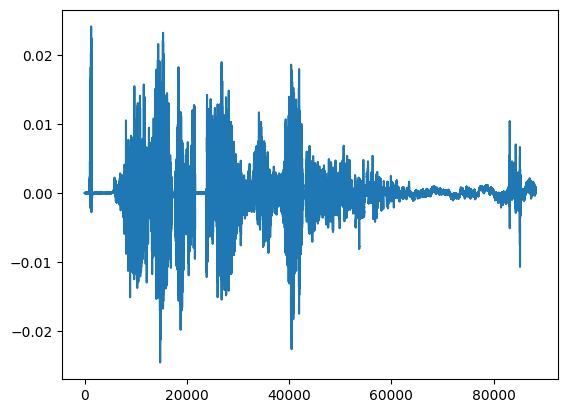

In [81]:
plt.plot(val1)

# Metadata structure for recordings

* id - unique identifier
* sampling_rate
* sample_length
* file_name
* label

In [82]:
record_number = 10
count = 0
fs = 44100
duration = 2
meta_data_file = 'meta.txt'
label = 'one'
meta_data = {}

f = open(meta_data_file, mode='w')

#collect n number of samples
for i in range (record_number):

    print ("Recording...")
    f_name = str(count)

    meta_data['id'] = uuid.uuid4().hex
    meta_data['sampling_rate'] = fs
    meta_data['duration'] = duration
    meta_data['file_name'] = str(count) + '.npy'
    meta_data['label'] = label

    #sample data from mic
    val = sd.rec(frames=fs*duration, samplerate=fs, channels=1)
    sd.wait()

    # transform obj to string
    meta_json_data = json.dumps(meta_data)
    f.write(meta_json_data + '\n')


    np.save(f_name+'.npy',val)

    count += 1
    print ("Recording...Done")
    print('meta info:', meta_data)

f.close()
print ("Recording...Done")

Recording...
Recording...Done
meta info: {'id': '737e1b5736934d7098c161316c0abc28', 'sampling_rate': 44100, 'duration': 2, 'file_name': '0.npy', 'label': 'one'}
Recording...
Recording...Done
meta info: {'id': '3f35feddbe64438ea4d629dc53be60f7', 'sampling_rate': 44100, 'duration': 2, 'file_name': '1.npy', 'label': 'one'}
Recording...
Recording...Done
meta info: {'id': '86bda4c08ab9401f8c45f9aa2e1f347c', 'sampling_rate': 44100, 'duration': 2, 'file_name': '2.npy', 'label': 'one'}
Recording...
Recording...Done
meta info: {'id': '1000b2e8c9f1428ea0dc00d0a5b05b01', 'sampling_rate': 44100, 'duration': 2, 'file_name': '3.npy', 'label': 'one'}
Recording...
Recording...Done
meta info: {'id': 'a12b5be6241448a8879bfb08265dc78e', 'sampling_rate': 44100, 'duration': 2, 'file_name': '4.npy', 'label': 'one'}
Recording...
Recording...Done
meta info: {'id': 'a79e1c396cf14b41a0fcb784548893b6', 'sampling_rate': 44100, 'duration': 2, 'file_name': '5.npy', 'label': 'one'}
Recording...
Recording...Done
meta

# meta data loader

Has the task to load the file in arrays

In [83]:
def data_loader(file_name):
    f = open(file_name,'r')

    data = []
    lines = f.readlines()

    for l in lines:
        obj_data = json.loads(l)
        data.append(obj_data)

    f.close()
    return data

In [94]:
data = data_loader('meta.txt')

In [95]:
print(data[0])

{'id': '737e1b5736934d7098c161316c0abc28', 'sampling_rate': 44100, 'duration': 2, 'file_name': '0.npy', 'label': 'one'}


#create a loader pipeline based on the Sequence tf object
-  this shall load the effective data into batches as needed

In [86]:
label_transform_dict = {
    'one': 1,
    'two': 2
}
class cDataLoader(tf.keras.utils.Sequence):

    def __init__(self, data, batch_size=8, shuffle=True, label_dict = label_transform_dict):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data = np.array(data)
        self.label_dict = label_dict


    def __len__(self):
        return math.ceil(len(self.data)/self.batch_size)

    def __getitem__(self, idx):
        batch_data = self.data[idx* self.batch_size:(idx+1)*self.batch_size]


        X = []
        y = []
        for batch in batch_data:
            #upload the sound data
            val = np.load(batch['file_name'])
            label = batch['label']

            X.append(val)
            y.append(self.label_dict[label])

        X = np.array(X)
        y = np.array(y)


        return X, y

    def on_epoch_end(self):

        if self.shuffle:
            np.random.shuffle(self.data)


In [87]:
obj_data = cDataLoader(data,1,shuffle=True)
print(obj_data[0][0])

[[[ 0.00000000e+00]
  [ 0.00000000e+00]
  [-3.05175781e-05]
  ...
  [ 1.21154785e-02]
  [ 1.21765137e-02]
  [ 1.21459961e-02]]]


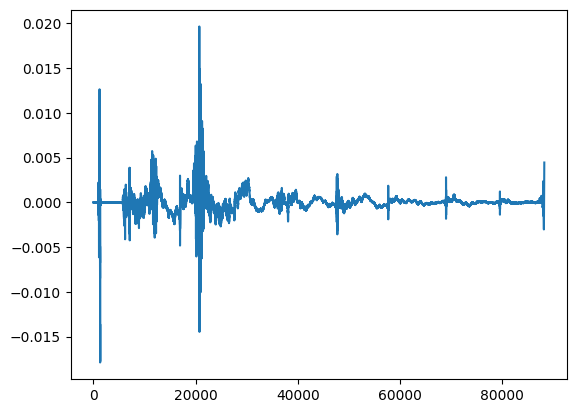

In [88]:
plt.plot(obj_data[3][0][0])

In [108]:

# mix the data

np.random.shuffle(data)
print(data)


train, test, val = np.split(data, [int(len(data)*0.7),int(len(data)*0.8)])

print(len(train),len(val),len(test))

[{'id': '1000b2e8c9f1428ea0dc00d0a5b05b01', 'sampling_rate': 44100, 'duration': 2, 'file_name': '3.npy', 'label': 'one'}, {'id': 'a79e1c396cf14b41a0fcb784548893b6', 'sampling_rate': 44100, 'duration': 2, 'file_name': '5.npy', 'label': 'one'}, {'id': 'a12b5be6241448a8879bfb08265dc78e', 'sampling_rate': 44100, 'duration': 2, 'file_name': '4.npy', 'label': 'one'}, {'id': '231f0ac67c974d5ba44f7f121479093a', 'sampling_rate': 44100, 'duration': 2, 'file_name': '7.npy', 'label': 'one'}, {'id': '86bda4c08ab9401f8c45f9aa2e1f347c', 'sampling_rate': 44100, 'duration': 2, 'file_name': '2.npy', 'label': 'one'}, {'id': '53e1c3c948344e329ac034a58f1c7cd7', 'sampling_rate': 44100, 'duration': 2, 'file_name': '9.npy', 'label': 'one'}, {'id': '3f35feddbe64438ea4d629dc53be60f7', 'sampling_rate': 44100, 'duration': 2, 'file_name': '1.npy', 'label': 'one'}, {'id': '146573c5ba9c4735ab43b090b31dee43', 'sampling_rate': 44100, 'duration': 2, 'file_name': '8.npy', 'label': 'one'}, {'id': '737e1b5736934d7098c1613

# HomeWork
- use your specific labels to create 100 recordings for each (total = 200)
- record 200 samples as negative (i.e. background noise, other words different from what you have)
- create under data/sound/"meta.txt"
- prepare cDataLoader object to be able to read the data, shuffle data and split into train, validation, test (70%,20%,10%)
